<h1>Using SHAP for measuring the contirbution from the features</h1>

This notebook is provided to show the usage of SHAP for measuring the contirbution from the features.

NOTE: The script used 3rd module <a href=https://github.com/slundberg/shap>SHAP</a> for feature measuring and <a href=https://logomaker.readthedocs.io/en/latest/examples.html>Logo maker</a> for LOGO figure plotting.

<h2>1. Preparation</h2>

In this notebook, few packages are necessary. 

Assuming that we are in <b>'root-of-autoBioSeqpy/notebook'</b>, then we need to add the search path and import the modules.

Please install <b>logomaker, SHAP, matplotlib, tensorFlow and keras</b> before using this notebook.

In [1]:
import os, sys
sys.path.append('../tool/libs')
sys.path.append('../')
oriPath = os.path.curdir
import paraParser
import moduleRead
import dataProcess
#import analysisPlot
import numpy as np
#from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,recall_score,precision_score,confusion_matrix,matthews_corrcoef 
import tensorflow as tf
# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior() 
from utils import TextDecorate, evalStrList
# from keras.models import Model
# from keras.models import Sequential

# import umap
# import umap.plot
# import matplotlib.pyplot as plt
# from matplotlib.backends.backend_pdf import PdfPages

Using TensorFlow backend.


In [2]:
#os.environ["CUDA_VISIBLE_DEVICES"] = '-1' #if CUDA related error occured, uncomment this line

Before using SHAP, we need the model and the data.

<h3>1.1 Model building</h3>

Like the binary case, using running.py  could build a model:

<b>python running.py --dataType dna --dataEncodingType onehot --dataTrainFilePaths examples/CRISPRCas9guideefficiency/data/Doench_high_activity_sgRNA.txt examples/CRISPRCas9guideefficiency/data/Doench_low_activity_sgRNA.txt --dataTrainLabel 1 0 --dataSplitScale 0.8 --modelLoadFile examples/CRISPRCas9guideefficiency/model/DNA_CNN2D_model.py --verbose 1 --outSaveFolderPath tmpOut --savePrediction 1 --saveFig 1 --batch_size 25 --epochs 40 --shuffleDataTrain 1 --spcLen 30 --firstKernelSize 4 5 --modelSaveName tmpMod.json --weightSaveName tmpWeight.bin --noGPU 0 --paraSaveName parameters.txt
</b>

The outputs will be saved at <b>../tmpOut</b>, including the parameters, the path of the data and constructure of the model.

If users would like to use their own model, please don't forget to save the model and the weight by using parameters "--modelSaveName" and "--weightSaveName".

<h3>1.2 Parameter pasering and data loading</h3>
The parameters are saved in <b>../tmoOut/parameters.txt</b>, we can get the information easily by using the <b>paraParser</b> module.

In [3]:
paraFile = '../tmpOut/parameters.txt'
paraDict = paraParser.parseParametersFromFile(paraFile)
#print
for k in paraDict:
    print('%r: %r' %(k,paraDict[k]))

'dataType': ['dna']
'dataEncodingType': ['onehot']
'spcLen': [30]
'firstKernelSize': ['4', '5']
'dataTrainFilePaths': ['examples/CRISPRCas9guideefficiency/data/Doench_high_activity_sgRNA.txt', 'examples/CRISPRCas9guideefficiency/data/Doench_low_activity_sgRNA.txt']
'dataTrainLabel': [1, 0]
'dataTestFilePaths': []
'dataTestLabel': []
'dataTrainModelInd': []
'dataTestModelInd': []
'outSaveFolderPath': 'tmpOut'
'showFig': True
'saveFig': True
'figDPI': 300
'savePrediction': True
'dataSplitScale': 0.8
'modelLoadFile': ['examples/CRISPRCas9guideefficiency/model/DNA_CNN2D_model.py']
'weightLoadFile': []
'shuffleDataTrain': True
'shuffleDataTest': False
'batch_size': 25
'epochs': 40
'useKMer': []
'KMerNum': []
'inputLength': []
'loss': 'binary_crossentropy'
'optimizer': 'optimizers.Adam()'
'metrics': ['acc', 'acc']
'modelSaveName': 'tmpMod.json'
'weightSaveName': 'tmpWeight.bin'
'noGPU': False
'paraFile': None
'paraSaveName': 'parameters.txt'
'seed': 1
'labelToMat': False
'colorText': 'Auto'


Then using <b>predicting</b> module could help us get the model and the datasets.

In [4]:
import predicting

Here we need some modification to specify the dataset due to the layer plotting needs the training dataset.

In [5]:
paraDict['dataTestFilePaths'] = paraDict['dataTrainFilePaths']
paraDict['dataTestModelInd'] = paraDict['dataTrainModelInd']
paraDict['dataTestLabel'] = paraDict['dataTrainLabel']

In [6]:
os.chdir('../')#to the root path of autoBioSeqpy

In [7]:
predictedLabel,predicted_Probability,testNameLists,testDataMats,testLabelArr,model = predicting.predict(paraDict)    




Enconding DNA data for model 0 ...
Checking the number of test files, which should be larger than 1 (e.g. at least two labels)...
Begin to generate test dataset...
Test datasets generated.
begin to prepare model...
Checking module file for modeling
Loading module and weight file
Building model...
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Module loaded, generating the summary of the module
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 20, 6, 1)          0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 115481    
Total params: 115,481
Trainable params: 115,481
Non-trainable params: 0
_________________________________________________________________
outpath tmpOut is exists, the outputs might be overwirten



Please note that the test label will NOT used for predicting, thus we have to generate it manually.

In [8]:
featureGenerators = []
dataTypeList = paraDict['dataType']
verbose = False
dataEncodingType = paraDict['dataEncodingType']
KMerNumList = useKMerList = [False] * 400
dataTestFilePaths = paraDict['dataTestFilePaths']
modelLoadFile = paraDict['modelLoadFile']
dataTestModelInd = paraDict['dataTestModelInd']
spcLen = paraDict['spcLen']
for i,subDataType in enumerate(dataTypeList):
    if subDataType.lower() == 'protein':
        if verbose:
            td.printC('Enconding protein data for model %d ...' %i,'b')
        featureGenerator = dataProcess.ProteinFeatureGenerator(dataEncodingType[i], useKMer=useKMerList[i], KMerNum=KMerNumList[i])
    elif subDataType.lower() == 'dna':
        if verbose:
            td.printC('Enconding DNA data for model %d ...' %i,'b')
        featureGenerator = dataProcess.DNAFeatureGenerator(dataEncodingType[i], useKMer=useKMerList[i], KMerNum=KMerNumList[i])
    elif subDataType.lower() == 'rna':
        if verbose:
            td.printC('Enconding RNA data for model %d ...' %i,'b')
        featureGenerator = dataProcess.RNAFeatureGenerator(dataEncodingType[i], useKMer=useKMerList[i], KMerNum=KMerNumList[i])
    elif subDataType.lower() == 'other':
        if verbose:
            td.printC('Reading CSV-like data for model %d ...' %i,'b')
        featureGenerator = dataProcess.OtherFeatureGenerator()
    else:
        td.printC('Unknow dataType %r, please use \'protein\', \'dna\' ,\'rna\' or \'other\'' %subDataType, 'r')
    featureGenerators.append(featureGenerator)
    assert subDataType.lower() in ['protein','dna','rna','other']

if verbose:
    td.printC('Checking the number of test files, which should be larger than 1 (e.g. at least two labels)...','b')
assert len(dataTestFilePaths) > 0

if verbose:
    td.printC('Begin to generate test dataset...','b')

testDataLoadDict = {}    
for modelIndex in range(len(modelLoadFile)):
    testDataLoadDict[modelIndex] = []
#    testDataLoaders = []
for i,dataPath in enumerate(dataTestFilePaths):
    if i >= len(dataTestModelInd):
        modelIndex = 0
    else:
        modelIndex = dataTestModelInd[i]
    featureGenerator = featureGenerators[modelIndex]
    dataLoader = dataProcess.DataLoader(label = paraDict['dataTestLabel'][i], featureGenerator=featureGenerator)
    dataLoader.readFile(dataPath, spcLen = spcLen[modelIndex])
    testDataLoadDict[modelIndex].append(dataLoader)

testDataMats = []
testLabelArrs = []
testNameLists = []
for modelIndex in range(len(modelLoadFile)):
    testDataLoaders = testDataLoadDict[modelIndex]
    testDataSetCreator = dataProcess.DataSetCreator(testDataLoaders)
    testDataMat, testLabelArr, nameList = testDataSetCreator.getDataSet(toShuffle=False, withNameList=True)
    testDataMats.append(testDataMat)
    testLabelArrs.append(testLabelArr)
    testNameLists.append(nameList)
if verbose:
    td.printC('Test datasets generated.','g')
nameTemp = testNameLists[0]    
testDataMats, testLabelArrs, sortedIndexes = dataProcess.matAlignByName(testDataMats,nameTemp,testLabelArrs,testNameLists)
testNameLists = [nameTemp] * len(testNameLists)

tmpTempLabel = testLabelArrs[0]

Few printing operations for display the current information.

In [9]:
testLabelArr.shape

(736,)

In [10]:
print('%d matrix generated:\n' %(len(testDataMats)))
for i in range(len(testDataMats)):
    print('Matrix and label %d:' %i)
    print(testDataMats[i])
    print(testLabelArrs[i])
    print('\n')

1 matrix generated:

Matrix and label 0:
[[0 0 0 ... 0 0 1]
 [1 0 0 ... 1 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [1 0 0 ... 0 0 1]]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0

<h2>2 Using SHAP for feature measuring</h2>
SHAP is a good tool for understanding the contribution from the features in every sample. SHAP provides some functions for the visualization of the features, but here we only use SHAP for generating the SHAP values and then plot them in our way.

<b>Note</b>:Currently (2020.11.23) SHAP only support TF 1.x without significant issue, if change TF to 2.x, sometimes the SHAP will not work . In this work, autoBioSeqpy uses Keras with TF backend, thus please make sure the version of TF is correctly set. The model from autoBioSeqpy is compatible with both TF 1.x and 2.x and thus all the code in section 1 can be executed correctly. 

<h3>2.1 Preparation</h3>
SHAP need the TF/Torch/Keras model and the related inputs, which are generated in the last section, here just use them.

In [11]:
import shap
from keras.models import Model

In [12]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 20, 6, 1)          0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 115481    
Total params: 115,481
Trainable params: 115,481
Non-trainable params: 0
_________________________________________________________________


In [14]:
explainer = shap.DeepExplainer(model, testDataMats)

keras is no longer supported, please use tf.keras instead.


In [15]:
shap_values = explainer.shap_values(testDataMats)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [16]:
shap_values

[array([[ 0.00461699,  0.00187632, -0.00533595, ..., -0.01217839,
          0.00824894, -0.01389367],
        [-0.01561673, -0.00298473, -0.00295961, ...,  0.03585427,
          0.00578394,  0.00652199],
        [ 0.00756305, -0.0065225 , -0.00370937, ..., -0.01749751,
          0.00339105,  0.00937363],
        ...,
        [ 0.00253016,  0.00331331,  0.01204279, ..., -0.01932585,
          0.00440543,  0.00656119],
        [ 0.00300988,  0.00287651,  0.00949499, ..., -0.01218071,
          0.00068659,  0.00333115],
        [-0.00616127,  0.00028418, -0.00431902, ..., -0.00901911,
          0.00015477, -0.02117488]])]

Here we can check the dimension of the shap values with the inputs:

In [17]:
shap_values[0].shape

(736, 120)

In [18]:
testDataMats[0].shape

(736, 120)

In [19]:
testDataLoaders

In [20]:
print(len(testDataLoaders[0].names))
print(len(testDataLoaders[1].names))

368
368


In [21]:
testDataLoaders[1].seqs

{'Doench_low_activity_sgRNA.txt_1': 'GGGACACCAGCTCCTGCAGAGCTGAGGGAC',
 'Doench_low_activity_sgRNA.txt_2': 'ACGCTATCGCCCAGGGCGGGGAGGAGGAGT',
 'Doench_low_activity_sgRNA.txt_3': 'CTGCTACACATGTGTAATTTGTTTGGGCAC',
 'Doench_low_activity_sgRNA.txt_4': 'ACGGCGGCGGCGGGCGGGCGGCGCGGGTGG',
 'Doench_low_activity_sgRNA.txt_5': 'GCAACGCTATCGCCCAGGGCGGGGAGGAGG',
 'Doench_low_activity_sgRNA.txt_6': 'GTAGGAATCGGGTTTCAGCGTGTTGGGGAG',
 'Doench_low_activity_sgRNA.txt_7': 'TTTTGTCAGCATCCACCGTGTGGAAGGAGA',
 'Doench_low_activity_sgRNA.txt_8': 'TGGTCCCCCTGTCACCACAGCTACTGGGTC',
 'Doench_low_activity_sgRNA.txt_9': 'CTGGTCTCCACAAGCTCCATGTCCTGGATC',
 'Doench_low_activity_sgRNA.txt_10': 'TCTGCTACACATGTGTAATTTGTTTGGGCA',
 'Doench_low_activity_sgRNA.txt_11': 'TCGAGGAAAAGCAGGTACGAGGCCAGGGAG',
 'Doench_low_activity_sgRNA.txt_12': 'GCCAGAAATTTGGATCCATAGCCAGGGCCC',
 'Doench_low_activity_sgRNA.txt_13': 'ATCCAAATTTCTGGCTGCAAGTGCAGGAGT',
 'Doench_low_activity_sgRNA.txt_14': 'GGCACAGGGTGGTCCTGCGTGGTGTGGGAG',
 'Doench_low_ac

<h3>2.3 Visualize the SHAP values</h3>

Firstly, have a look of the format of SHAP values

In [23]:
print(len(shap_values))

1


In [24]:
print(shap_values[0].shape)

(736, 120)


In this work, the length of the sequence is set as 1500 and every sample has additional 420 features. Thus, it is clear that SHAP will score all the features of every samples respectively.

Now we can plot them separately, here is the plot of SHAP values of the sequences:

In [25]:
import analysisPlot

In [26]:
print(shap_values[0][0].shape)
print(shap_values[0][1].shape)

(120,)
(120,)


In [27]:
matForPlot = shap_values[0]

Since the SHAP values in a sample is comparable, a 0-1 scale is performed for every sample to make the plot better to look.

In [28]:
matForPlot = (matForPlot - matForPlot.min(axis=1).reshape(matForPlot.shape[0],1).dot(np.ones([1,matForPlot.shape[1]]))) / (matForPlot.max(axis=1).reshape(matForPlot.shape[0],1).dot(np.ones([1,matForPlot.shape[1]])) - matForPlot.min(axis=1).reshape(matForPlot.shape[0],1).dot(np.ones([1,matForPlot.shape[1]])))

Please note that the 120 below is the length (i.e. 30) * onehot dimesion (i.e. 4)

You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("coolwarm"))
FixedFormatter should only be used together with FixedLocator


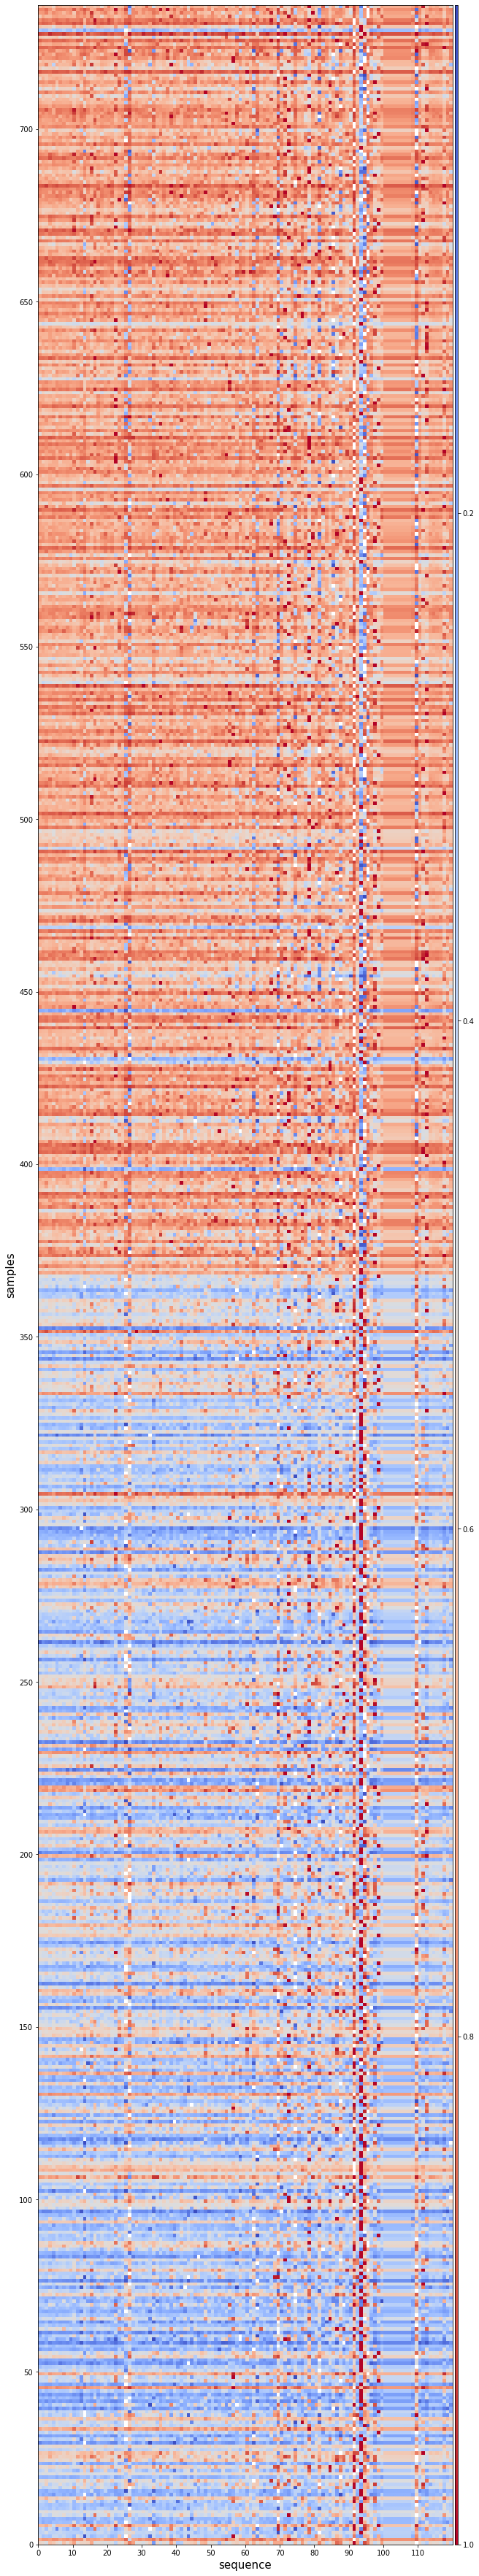

In [29]:
analysisPlot.showMatWithVal(matForPlot,showText=False,figSize=(32,64),cmapName='coolwarm',
                            yticks=np.arange(0,750,50),ytickLabels=np.arange(0,750,50),
                           xticks=np.arange(0,120,10),xtickLabels=np.arange(0,120,10),
                           xtitle='sequence',ytitle='samples',title_size=15,stick_size=10,
                            saveFig='./tmpOut/shapVal.pdf',saveDpi=300)

Sometimes the global vision is not enouph for figure out what happend in one or few samples, thus here we provided few cells to make detailed comarison:

In [31]:
#this function is to get the fasta seqs from the dataLoader
def getSampleSeqs(sampleIndex,testDataLoadDict):
    thres = len(testDataLoadDict[0][0].names)
    names = []
    outList = []
    for sampleID in sampleIndex:
        if sampleID < thres:
            label = 1
        else:
            label = 0
            sampleID = sampleID - thres
        dataLoader = testDataLoadDict[0][label]
        name = dataLoader.names[sampleID]
        seq = dataLoader.seqs[name]
        names.append(name)
        outList.append(list(seq))
    return np.array(outList,dtype=str),names



You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("coolwarm"))
FixedFormatter should only be used together with FixedLocator


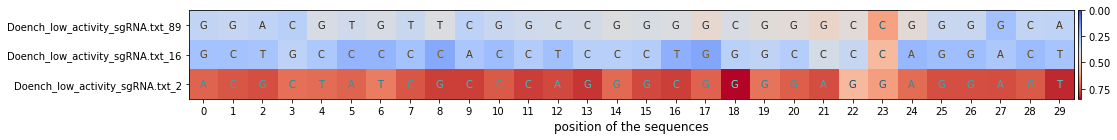

In [33]:
matForPlot = shap_values[0]
matForPlot = (matForPlot - matForPlot.min(axis=1).reshape(matForPlot.shape[0],1).dot(np.ones([1,matForPlot.shape[1]]))) / (matForPlot.max(axis=1).reshape(matForPlot.shape[0],1).dot(np.ones([1,matForPlot.shape[1]])) - matForPlot.min(axis=1).reshape(matForPlot.shape[0],1).dot(np.ones([1,matForPlot.shape[1]])))

sampleIndex = [1,15,88] #the rows in the matForPlot
fastaSeqs,names = getSampleSeqs(sampleIndex,testDataLoadDict)
subShapVals = matForPlot[sampleIndex,:].reshape([len(sampleIndex),-1,4]).mean(axis=-1) #simply use the average to measure the contirbution

startPos = 0 #start from 0
endPos = 30
part = slice(startPos,endPos)
analysisPlot.showMatWithText(subShapVals[:,part],fastaSeqs[:,part],vmin=-1e-5,cmapName='coolwarm',
                            xtickLabels = np.arange(startPos,endPos), ytickLabels=names,
                            xtitle='position of the sequences',title_size=12)

<h3>2.4 Visualize the SHAP using LOGO figure</h3>

Using the shap values we can plot the LOGO figure with module Logo maker, below are few demostration of the way generating the plots.

<h4>2.4.1 Preparation</h4>
Before plotting, we have to generate the data frame provided by pandas, which illustrate the relations between the alphabets and the values. Here we provide a class for the such things：<br>
1. Setting the position of the letters (i.e. the posDict).<br>
2. Add the shap values to the right position.<br>
3. Generate the data frame afterwards.<br>

Please note that if you don't want to provide the posDict manually, we provided a default one (i.e. the <i><b>self.posDict</b></i>) for <b>DNA</b> in this notebook, be sure the letters are the things you need, and you can change the default one as well.

In [34]:
import pandas as pd
import logomaker

In [35]:
class seqLogoPlot():
    def __init__(self,posDict=None,encodingType='oneHot'):
        if not posDict is None:
            self.posDict = posDict
        else:
            self.posDict = {'A':0,'G':1,'C':2,'T':3}
        self.posMatDict = {} #pos:resArr
        self.dim = len(list(self.posDict.keys()))
        self.colNames = ['']*self.dim
        for k in self.posDict:
            self.colNames[self.posDict[k]] = k
        self.encodingType = encodingType
        
    def addSeqWithVal(self,seq,vals,posList=None):
        if posList is None:
            posList = np.arange(len(seq),dtype=int)
        if self.encodingType == 'oneHot':
            for i,pos in enumerate(posList):
                if not pos in self.posMatDict:
                    self.posMatDict[pos] = np.zeros(self.dim,dtype=float)
#                 print(self.posMatDict[pos])
#                 print(vals[i])
                #self.posMatDict[pos][self.posDict[seq[i]]] += vals[i]
                self.posMatDict[pos] += vals[i]
        else:
            for i,pos in enumerate(posList):
                if not pos in self.posMatDict:
                    self.posMatDict[pos] = np.zeros(self.dim,dtype=float)
                resPos = self.posDict[seq[i]]
                self.posMatDict[pos][resPos] += vals[i]
            
    def generateDF(self):
        matList = []
        for pos in range(np.max(list(self.posMatDict.keys()))+1):
            matList.append(self.posMatDict[pos])
        outDF = pd.DataFrame(data=matList,  columns=self.colNames)
        outDF.index.name='pos'
        return outDF

In [36]:
def feedSeqs(dataLoader,vals,seqLogoPlotObj):
    for sampleID in range(len(dataLoader.seqs)):
        name = dataLoader.names[sampleID]
        seq = dataLoader.seqs[name]
#         print(len(seq))
        val = vals[sampleID]
        seqLogoPlotObj.addSeqWithVal(seq,val)


In [37]:
tmpObjPos = seqLogoPlot()
numRows = len(testDataLoaders[0].names)
feedSeqs(testDataLoaders[0],shap_values[0][:numRows,:].reshape(numRows,-1,4),tmpObjPos)

In [38]:
testDataLoadDict

{0: [<dataProcess.DataLoader at 0x7fce955e2d50>,
  <dataProcess.DataLoader at 0x7fce955e2e90>]}

In [39]:
crp_df = tmpObjPos.generateDF()

In [40]:
crp_df

,A,G,C,T
pos,,,,
0,0.021371,0.240480,0.188401,0.362428
1,0.175160,0.189141,0.176164,0.360729
2,0.252900,0.489015,0.462932,0.104720
3,-0.101166,0.893055,0.548304,0.404545
4,0.339325,0.231434,0.603231,0.306833
5,0.059412,0.250306,1.027172,0.445728
6,0.283192,1.662923,4.286424,1.263297
7,0.479899,0.430439,0.159139,0.490639
8,0.334113,0.974760,0.813645,0.169998


<h4>2.4.2 plotting the LOGO figure</h4>
Please note that, in this example, the length of the protein is 1500, which is too long to plot all the LOGOs in one figure, thus here we only use the first 30 residues for plotting.

<h5>2.4.2.1 general plotting</h5>
Here we can use the code provide by Loge maker for the first plotting. Somehow the information seems too much.

findfont: Font family ['Arial Rounded MT Bold'] not found. Falling back to DejaVu Sans.


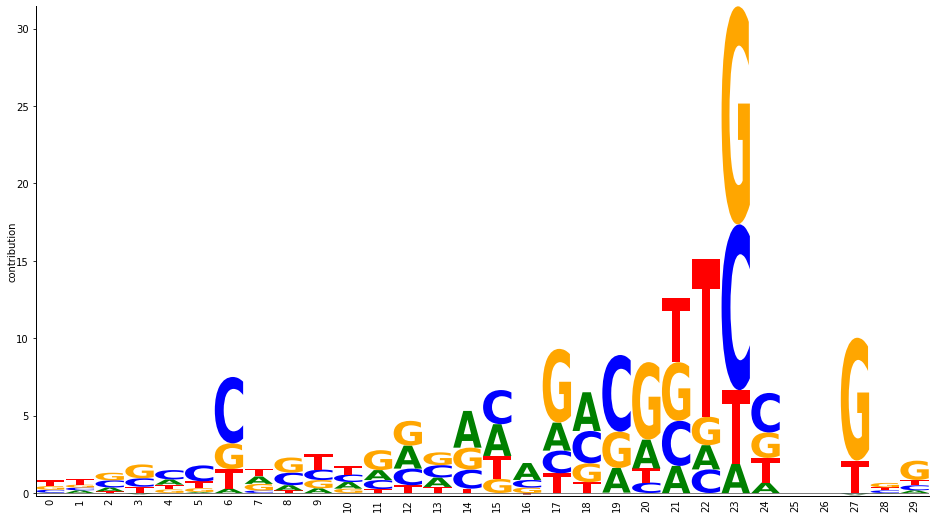

In [41]:
crp_logo = logomaker.Logo(crp_df,
                          shade_below=.5,
                          fade_below=.5,
                          font_name='Arial Rounded MT Bold',
                         figsize=(16,9))

# style using Logo methods
crp_logo.style_spines(visible=False)
crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
crp_logo.style_xticks(rotation=90, fmt='%d', anchor=0)

# style using Axes methods
crp_logo.ax.set_ylabel("contribution", labelpad=-1)
crp_logo.ax.xaxis.set_ticks_position('none')
crp_logo.ax.xaxis.set_tick_params(pad=-1)

# style and show figure
crp_logo.fig.show()

<h5>2.4.2.2 plotting with threshold</h5>
To reduce the less important information, here we set a threhold for filtering.

In [52]:
global_threshold = 1.
crp_df1 = crp_df.copy()
crp_df1.iloc[crp_df1<global_threshold] = 0

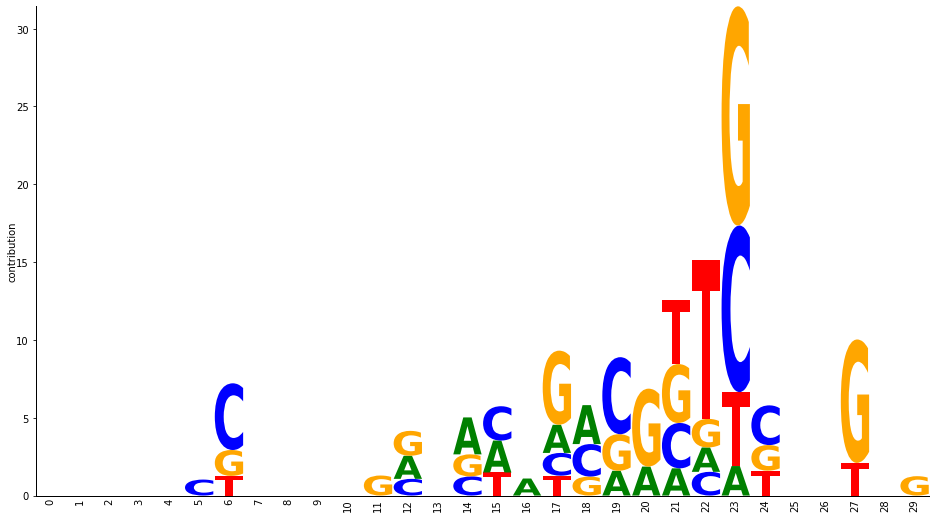

In [53]:
crp_logo = logomaker.Logo(crp_df1,
                          shade_below=.5,
                          fade_below=.5,
                          font_name='Arial Rounded MT Bold',
                         figsize=(16,9))

# style using Logo methods
crp_logo.style_spines(visible=False)
crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
crp_logo.style_xticks(rotation=90, fmt='%d', anchor=0)

# style using Axes methods
crp_logo.ax.set_ylabel("contribution", labelpad=-1)
crp_logo.ax.xaxis.set_ticks_position('none')
crp_logo.ax.xaxis.set_tick_params(pad=-1)

# style and show figure
crp_logo.fig.show()

<h5>2.4.2.3 plotting with row wise scaling</h5>
Similarily, we can scale the values of every row (i.e. every residue) into [-1,1], which can make the filtering different.

In [47]:
global_threshold = 0.2
crp_df2 = crp_df.copy()
# crp_df2.iloc[crp_df2<global_threshold] = 0
for i in range(crp_df2.shape[0]):
    tmpArr = crp_df2.copy().iloc[i,:]
    if np.max(tmpArr)-np.min(tmpArr) == 0:
        continue
    crp_df2.iloc[i,:] = ((tmpArr-np.min(tmpArr)) / (np.max(tmpArr)-np.min(tmpArr)) - 0.5) / 2

# crp_df2 = ((diff / scale) - 0.5) / 2
crp_df2[crp_df2.abs()<global_threshold] = 0

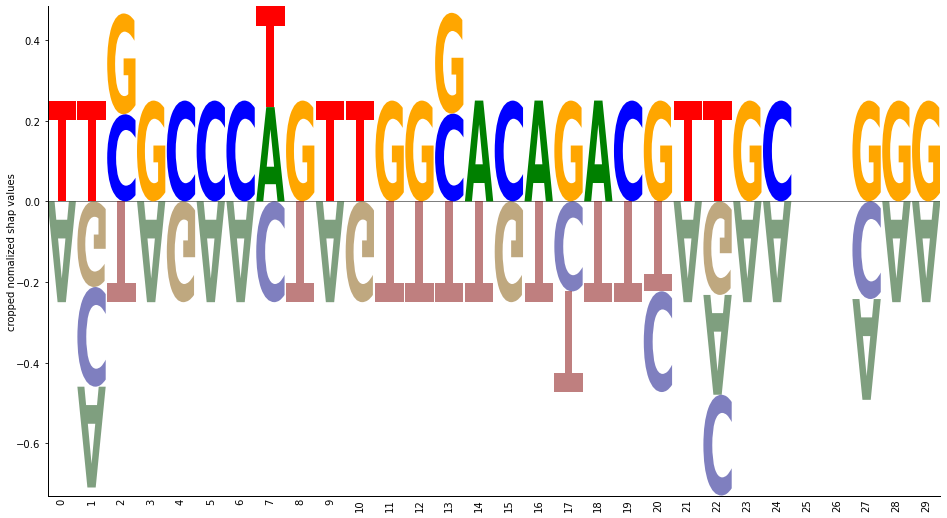

In [48]:
crp_logo = logomaker.Logo(crp_df2,
                          shade_below=.5,
                          fade_below=.5,
                          font_name='Arial Rounded MT Bold',
                         figsize=(16,9))

# style using Logo methods
crp_logo.style_spines(visible=False)
crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
crp_logo.style_xticks(rotation=90, fmt='%d', anchor=0)

# style using Axes methods
crp_logo.ax.set_ylabel("cropped nomalized shap values", labelpad=-1)
crp_logo.ax.xaxis.set_ticks_position('none')
crp_logo.ax.xaxis.set_tick_params(pad=-1)



# style and show figure
crp_logo.fig.show()

<h5>2.4.2.4 plotting with row wise softmax</h5>
Finally, we would like to show the widely used nomalization in deep learning named 'softmax': $$ \dfrac{x_i}{\sum_{j} exp(x_j)} $$<br>
Additionally, the threshold is set to 0.25, which is the average of 4 elements with sum of 1.

In [50]:
global_threshold = 1/4
crp_df3= crp_df.copy()
# crp_df2.iloc[crp_df2<global_threshold] = 0
for i in range(crp_df3.shape[0]):
    tmpArr = np.exp(crp_df3.copy().iloc[i,:])
    crp_df3.iloc[i,:] = tmpArr/tmpArr.sum()

# crp_df2 = ((diff / scale) - 0.5) / 2
crp_df3[crp_df3.abs()<=global_threshold] = 0

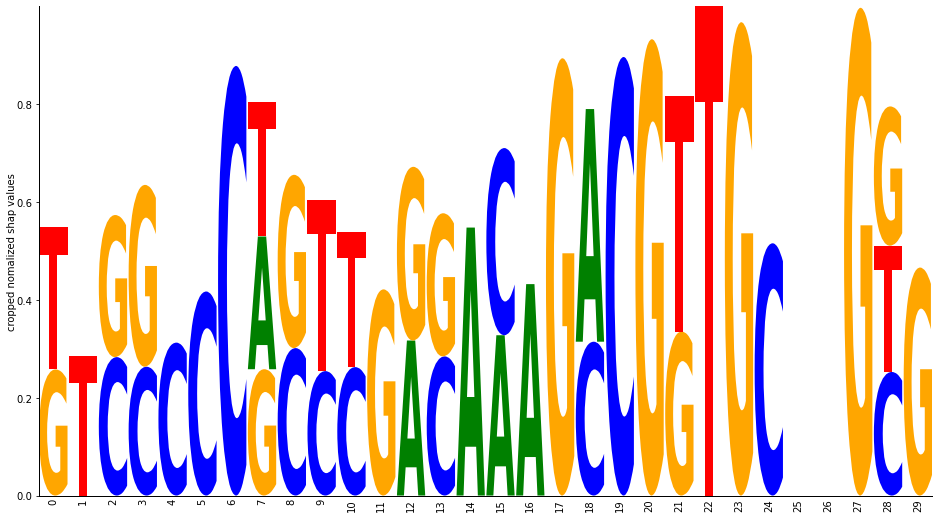

In [51]:
crp_logo = logomaker.Logo(crp_df3,
                          shade_below=.5,
                          fade_below=.5,
                          font_name='Arial Rounded MT Bold',
                         figsize=(16,9))

# style using Logo methods
crp_logo.style_spines(visible=False)
crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
crp_logo.style_xticks(rotation=90, fmt='%d', anchor=0)

# style using Axes methods
crp_logo.ax.set_ylabel("cropped nomalized shap values", labelpad=-1)
crp_logo.ax.xaxis.set_ticks_position('none')
crp_logo.ax.xaxis.set_tick_params(pad=-1)



# style and show figure
crp_logo.fig.show()

That's all the informations for this notebook. If you still have more issues, please fell free to connect us at ljs@swmu.edu.cn, thanks.